基于 Prompt API 实现人类价值观分类
1. 任务说明
随着预训练语言模型规模的增长，“预训练-微调”范式在下游自然语言处理任务上的表现越来越好，但与之相应地对训练数据量和计算存储资源的要求也越来越高。为了充分利用预训练语言模型学习到的知识，同时降低对数据和资源的依赖，提示学习（Prompt Learning）作为一种可能的新范式受到了越来越多的关注，在 FewCLUE、SuperGLUE 等榜单的小样本任务上取得了远优于传统微调范式的结果。

提示学习（Prompt Learning）的核心思想是将下游任务转化为预训练阶段的掩码预测（MLM）任务。实现思路包括通过模板（Template）定义的提示语句，将原有任务转化为预测掩码位置的词，以及通过标签词（Verbalizer）的定义，建立预测词与真实标签之间的映射关系。

以情感分类任务为例，“预训练-微调”范式和“预训练-提示”范式（以 PET 为例）之间的区别如下图所示
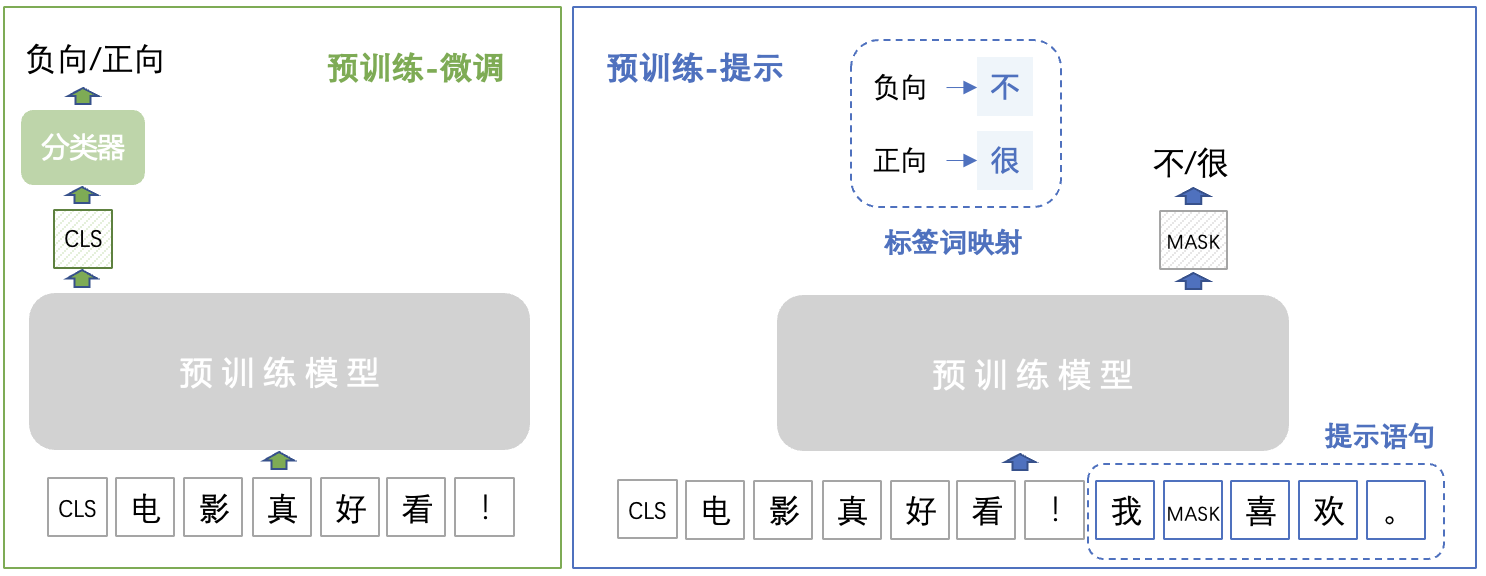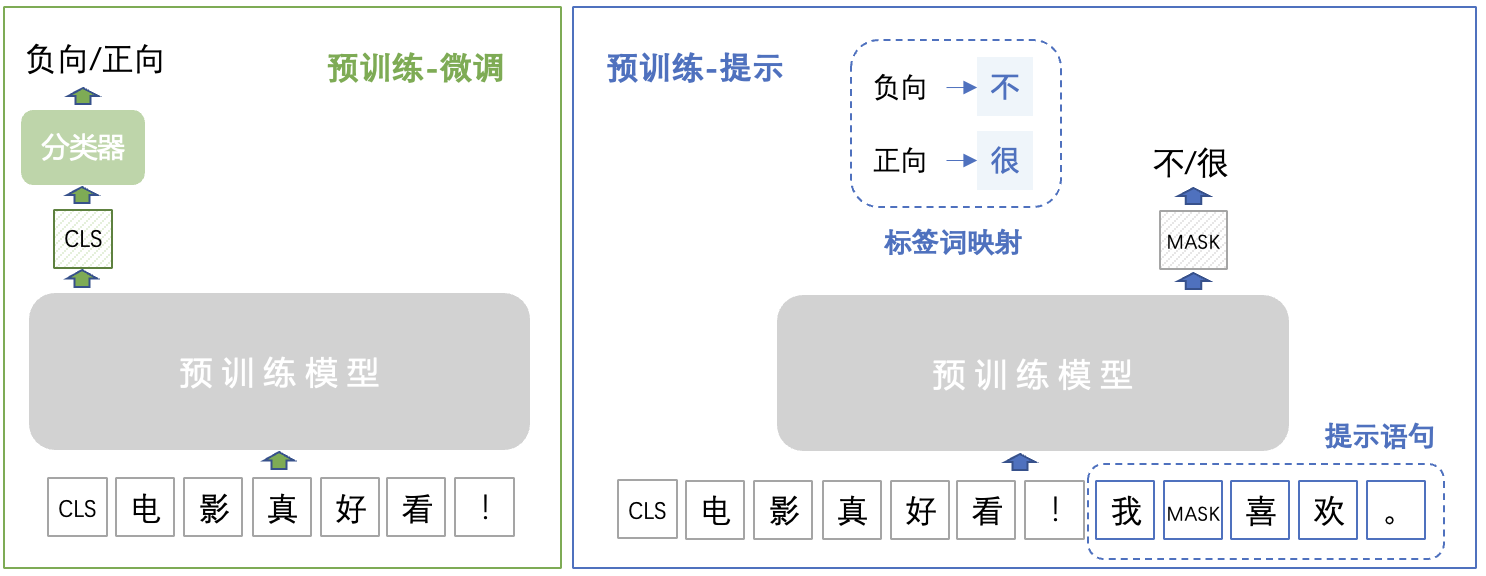


【微调学习】使用 [CLS] 来做分类，需要训练随机初始化的分类器，需要充分的训练数据来拟合。

【提示学习】通过提示语句和标签词映射的定义，转化为 MLM 任务，无需训练新的参数，适用于小样本场景。

本实践使用 PaddleNLP 的 Prompt API 来快速实现基于 ERNIE 2.0 的人类价值观分类。

2. 实现思路及流程
基于 Prompt API 实现文本分类的思路如下所示，模型的输入文本根据模板（Template）进行预处理，模型的输出结果经过标签词映射（Verbalizer）得到预测的映射词。

在建模过程中，对于输入文本，首先将其处理为模板 API 能够处理的标准形式，根据任务定义模板和标签词映射，调用模板 API 进行文本模板组合和文本序列编码，获得文本的语义向量表示；然后经过预训练语言模型得到预测向量，调用标签词映射的 API 取出标签词对应的概率。

根据上边介绍，基于 Prompt API 实现多标签分类的过程主要包括以下6个步骤：

（1）模型构建：确定文本分类使用的模型，本实践使用ERNIE-3.0 Base模型进行文本编码和标签词预测。

（2）数据准备：对于输入的文本进行相应的处理，包括数据标准化、模板定义、标签词映射、文本编码等。

（3）训练配置：配置训练参数，使用 PromptTrainer API 进行环境、模型、优化器、训练预测等流程的自动初始化。

（4）模型训练：训练模型参数，以达到最优效果。

（5）模型评估：对训练好的模型进行评估测试，观察准确率和损失函数的变化情况。

（6）模型预测：选取一段新闻，判断新闻类别。

以下分别介绍每个步骤的具体实现过程。

In [1]:
!pip install --upgrade paddlenlp

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 45.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 219.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 33.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 55.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 1.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 42.0 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.11.0
    Uninstalling huggingface-hub-0.11.0:
      Successfully uninstalled huggingface-hub-0.11.0
  Attempting uninstall: paddlenlp
    Found existing installation: paddlenlp 2.4.2
    Uninstalling paddlenlp-2.4.2:
    

In [2]:
!pip install --upgrade paddle2onnx

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 3.0/3.0 MB 13.7 MB/s eta 0:00:0100:01The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: paddle2onnx
    Found existing installation: paddle2onnx 1.0.0
    Uninstalling paddle2onnx-1.0.0:
      Successfully uninstalled paddle2onnx-1.0.0

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


3. 模型构建
我们使用ERNIE 2.0 Large作为预训练模型用于新闻分类。提示学习本质上是掩码预测（MLM）任务，因此可以使用 AutoModelForMaskedLM 来加载模型参数。

In [4]:
import os
from collections import defaultdict
from dataclasses import dataclass, field

import paddle
import paddle.nn.functional as F
from paddlenlp.prompt import (
    AutoTemplate,
    PromptModelForSequenceClassification,
    PromptTrainer,
    PromptTuningArguments,
    SoftVerbalizer,
)
from paddlenlp.trainer import EarlyStoppingCallback, PdArgumentParser
from paddlenlp.transformers import AutoModelForMaskedLM, AutoTokenizer
from paddlenlp.utils.log import logger

In [5]:
from paddlenlp.transformers import AutoTokenizer, AutoModelForMaskedLM

model = AutoModelForMaskedLM.from_pretrained("ernie-2.0-large-en")
tokenizer = AutoTokenizer.from_pretrained("ernie-2.0-large-en")

[2023-01-15 22:05:27,714] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForMaskedLM'> to load 'ernie-2.0-large-en'.
[2023-01-15 22:05:27,717] [    INFO] - Model config ErnieConfig {
  "attention_probs_dropout_prob": 0.1,
  "enable_recompute": false,
  "fuse": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "ernie",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "paddlenlp_version": null,
  "pool_act": "tanh",
  "task_id": 0,
  "task_type_vocab_size": 3,
  "type_vocab_size": 4,
  "use_task_id": true,
  "vocab_size": 30522
}

[2023-01-15 22:05:27,720] [    INFO] - Configuration saved in /home/aistudio/.paddlenlp/models/ernie-2.0-large-en/config.json
[2023-01-15 22:05:27,722] [    INFO] - Downloading ernie_v2_eng_large.pdparams from https://bj.bcebos.com/padd

4. 数据准备
数据准备过程包括数据集确定、数据标准化、模板定义、标签词映射定义等步骤。本实践使用 PromptTrainer 进行训练，该 API 封装了 Prompt 相关的数据预处理过程，如模板文本组合和文本分词、编码的过程，因此不需要构造 DataLoader。

（1）数据集确定
FewCLUE 是专门用于中文小样本学习能力测评的榜单，涵盖了情感分析、新闻分类、语义匹配、指代消歧等阅读理解任务。这里我们使用其中的新闻分类数据集 TNEWS 作为示例，共包括15个新闻类别，每个类别有16条标注数据用于训练。除此之外，有240条标注数据用于验证，2010条数据用于测试。

PaddleNLP 中内置了该数据集，可直接调用 load_dataset 加载数据。

In [10]:
from paddlenlp.datasets import load_dataset
def load_local_dataset(data_path, splits, label_list):
    """
    Load dataset for multi-label classification from files, where
    there is one example per line. Text and label are seperated
    by '\t', and multiple labels are delimited by ','.
    Args:
        data_path (str):
            Path to the dataset directory, including label.txt, train.txt,
            dev.txt (and data.txt).
        splits (list):
            Which file(s) to load, such as ['train', 'dev', 'test'].
        label_list (dict):
            The dictionary that maps labels to indeces.
    """

    def _reader(data_file, label_list):
        with open(data_file, "r", encoding="utf-8") as fp:
            next(fp)
            for idx, line in enumerate(fp):
                data = line.strip().split("\t")
                if len(data) == 2:
                    yield {"text_a": data[1]}
                else:
                    text= data[1]
                    label = data[2] 
                    label = label[1:-1].strip().split(",")
                    label = [float(x) for x in label]
                    yield {"text_a": text, "labels": label}

    split_map = {"train": "train.tsv", "dev": "dev.tsv", "test": "test.tsv"}
    datasets = []
    for split in splits:
        data_file = os.path.join(data_path, split_map[split])
        datasets.append(load_dataset(_reader, data_file=data_file, label_list=label_list, lazy=False))
    return datasets

数据标准化
Prompt API 规定了输入数据的格式，我们需要先将已有数据转化为 InputExample 封装的标准格式。

In [7]:
from paddlenlp.prompt import SoftVerbalizer
from collections import defaultdict

label_file =  "label.txt"
with open(label_file, "r", encoding="utf-8") as fp:
    label_words = defaultdict(list)
    for line in fp:
        data = line.strip().split("==")
        word = data[1] if len(data) > 1 else data[0].split("##")[-1]
        label_words[data[0]].append(word)

verbalizer = SoftVerbalizer(label_words, tokenizer, model)

In [8]:
ls

11.ipynb               dataprocessprompt.ipynb  prompt.ipynb
checkpoint/            label.txt                Untitled1.ipynb
checkpoints/           main.ipynb               valid_zhihuERNIE2.0Prompt.tsv
data/                  model/                   work/
dataprocess (2).ipynb  prompt/                  第一次才行.ipynb


In [12]:
import os
train_ds, dev_ds, test_ds = load_local_dataset(
        "data/", splits=["train", "dev", "test"], label_list=verbalizer.labels_to_ids
    )

# test_ds,test2_ds = load_local_dataset(
#          "data/", splits=["test","test2"], label_list=verbalizer.labels_to_ids)

In [6]:
dev_ds[0]

{'text_a': '"Imagine someone is arguing in favor of ""Entrapment should be legalized"" by saying: ""if entrapment can serve to more easily capture wanted criminals, then why shouldn\'t it be legal?""."',
 'labels': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

In [13]:
from paddlenlp.prompt import AutoTemplate

prompt = "The values implicit in this sentence include:"
template = AutoTemplate.create_from(
        prompt,
        tokenizer,
        max_length=512,
        model=model)

In [14]:
prompt_model = PromptModelForSequenceClassification(
        model, template, verbalizer, freeze_plm=False, freeze_dropout=False
    )

In [15]:
prompt_model

PromptModelForSequenceClassification(
  (plm): ErnieForMaskedLM(
    (ernie): ErnieModel(
      (embeddings): ErnieEmbeddings(
        (word_embeddings): Embedding(30522, 1024, padding_idx=0, sparse=False)
        (position_embeddings): Embedding(512, 1024, sparse=False)
        (token_type_embeddings): Embedding(4, 1024, sparse=False)
        (task_type_embeddings): Embedding(3, 1024, sparse=False)
        (layer_norm): LayerNorm(normalized_shape=[1024], epsilon=1e-12)
        (dropout): Dropout(p=0.1, axis=None, mode=upscale_in_train)
      )
      (encoder): TransformerEncoder(
        (layers): LayerList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiHeadAttention(
              (q_proj): Linear(in_features=1024, out_features=1024, dtype=float32)
              (k_proj): Linear(in_features=1024, out_features=1024, dtype=float32)
              (v_proj): Linear(in_features=1024, out_features=1024, dtype=float32)
              (out_proj): Linear(in_features=1024

模型训练

In [9]:
# 训练参数
config = ["--output_dir", "./checkpoints/", 
          "--learning_rate", "3e-5",
          "--ppt_learning_rate", "3e-4",
          "--num_train_epochs", "20",
          "--logging_steps", "5",
          "--per_device_train_batch_size", "8",
          "--per_device_eval_batch_size", "8",
          "--metric_for_best_model", "macro_f1_score",
          "--load_best_model_at_end", "True",
          "--evaluation_strategy", "epoch",
          "--save_strategy", "epoch",
          "--load_best_model_at_end", "True",
          "--save_total_limit", "1"
         ]
parser = PdArgumentParser((PromptTuningArguments,))
training_args = parser.parse_args_into_dataclasses(args=config,
                                                   look_for_args_file=False)[0]

[2023-01-10 12:37:25,897] [    INFO] - The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [10]:
# Define the criterion.
criterion = paddle.nn.BCEWithLogitsLoss()

In [11]:
import numpy as np
from paddle.metric import Metric
from sklearn.metrics import classification_report, f1_score

from paddlenlp.utils.log import logger


class MetricReport(Metric):
    """
    F1 score for multi-label text classification task.
    """

    def __init__(self, name="MetricReport", average="micro"):
        super(MetricReport, self).__init__()
        self.average = average
        self._name = name
        self.reset()

    def reset(self):
        """
        Resets all of the metric state.
        """
        self.y_prob = None
        self.y_true = None

    def f1_score(self, y_prob):
        """
        Compute micro f1 score and macro f1 score
        """
        threshold = 0.5
        self.y_pred = y_prob > threshold
        micro_f1_score = f1_score(y_pred=self.y_pred, y_true=self.y_true, average="micro")
        macro_f1_score = f1_score(y_pred=self.y_pred, y_true=self.y_true, average="macro")
        return micro_f1_score, macro_f1_score

    def update(self, probs, labels):
        """
        Update the probability and label
        """
        if self.y_prob is not None:
            self.y_prob = np.append(self.y_prob, probs.numpy(), axis=0)
        else:
            self.y_prob = probs.numpy()
        if self.y_true is not None:
            self.y_true = np.append(self.y_true, labels.numpy(), axis=0)
        else:
            self.y_true = labels.numpy()

    def accumulate(self):
        """
        Returns micro f1 score and macro f1 score
        """
        micro_f1_score, macro_f1_score = self.f1_score(y_prob=self.y_prob)
        return micro_f1_score, macro_f1_score

    def report(self):
        """
        Returns classification report
        """
        self.y_pred = self.y_prob > 0.5
        logger.info("classification report:\n" + classification_report(self.y_true, self.y_pred, digits=4))

    def name(self):
        """
        Returns metric name
        """
        return self._name

In [12]:
 # Define the metric function.
def compute_metrics(eval_preds):
    metric = MetricReport()
    preds = F.sigmoid(paddle.to_tensor(eval_preds.predictions))
    metric.update(preds, paddle.to_tensor(eval_preds.label_ids))
    micro_f1_score, macro_f1_score = metric.accumulate()
    return {"micro_f1_score": micro_f1_score, "macro_f1_score": macro_f1_score}

In [16]:
# Deine the early-stopping callback.
#callbacks = [EarlyStoppingCallback(early_stopping_patience=4, early_stopping_threshold=0.0)]

In [15]:
# Trainer 定义
trainer = PromptTrainer(model=prompt_model,
                        tokenizer=tokenizer,
                        args=training_args,
                        criterion=criterion,
                        train_dataset=train_ds,
                        eval_dataset=dev_ds,
                        #callbacks=callbacks,
                        compute_metrics=compute_metrics)
             

[2023-01-10 12:38:59,759] [    INFO] - ============================================================
[2023-01-10 12:38:59,762] [    INFO] -     Training Configuration Arguments    
[2023-01-10 12:38:59,764] [    INFO] - paddle commit id              :3fa7a736e32508e797616b6344d97814c37d3ff8
[2023-01-10 12:38:59,766] [    INFO] - _no_sync_in_gradient_accumulation:True
[2023-01-10 12:38:59,768] [    INFO] - adam_beta1                    :0.9
[2023-01-10 12:38:59,770] [    INFO] - adam_beta2                    :0.999
[2023-01-10 12:38:59,772] [    INFO] - adam_epsilon                  :1e-08
[2023-01-10 12:38:59,774] [    INFO] - alpha_rdrop                   :5.0
[2023-01-10 12:38:59,776] [    INFO] - alpha_rgl                     :0.5
[2023-01-10 12:38:59,778] [    INFO] - bf16                          :False
[2023-01-10 12:38:59,780] [    INFO] - bf16_full_eval                :False
[2023-01-10 12:38:59,782] [    INFO] - current_device                :gpu:0
[2023-01-10 12:38:59,784] [  

In [17]:
# Training.
train_result = trainer.train(resume_from_checkpoint=None)
metrics = train_result.metrics
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[2023-01-10 10:38:28,580] [    INFO] - ***** Running training *****
[2023-01-10 10:38:28,583] [    INFO] -   Num examples = 5393
[2023-01-10 10:38:28,586] [    INFO] -   Num Epochs = 20
[2023-01-10 10:38:28,588] [    INFO] -   Instantaneous batch size per device = 8
[2023-01-10 10:38:28,590] [    INFO] -   Total train batch size (w. parallel, distributed & accumulation) = 8
[2023-01-10 10:38:28,592] [    INFO] -   Gradient Accumulation steps = 1
[2023-01-10 10:38:28,593] [    INFO] -   Total optimization steps = 13500.0
[2023-01-10 10:38:28,595] [    INFO] -   Total num train samples = 107860.0
[2023-01-10 10:38:28,609] [    INFO] -   Number of trainable parameters = 336219156


  0%|          | 0/13500 [00:00<?, ?it/s]

loss: 0.60583401, learning_rate: 2.999e-05, global_step: 5, interval_runtime: 1.8059, interval_samples_per_second: 22.15, interval_steps_per_second: 2.769, epoch: 0.0074
loss: 0.48748026, learning_rate: 2.998e-05, global_step: 10, interval_runtime: 0.7857, interval_samples_per_second: 50.912, interval_steps_per_second: 6.364, epoch: 0.0148
loss: 0.43271046, learning_rate: 2.997e-05, global_step: 15, interval_runtime: 0.8399, interval_samples_per_second: 47.627, interval_steps_per_second: 5.953, epoch: 0.0222
loss: 0.45458364, learning_rate: 2.996e-05, global_step: 20, interval_runtime: 0.8402, interval_samples_per_second: 47.607, interval_steps_per_second: 5.951, epoch: 0.0296
loss: 0.42122793, learning_rate: 2.994e-05, global_step: 25, interval_runtime: 0.7586, interval_samples_per_second: 52.728, interval_steps_per_second: 6.591, epoch: 0.037
loss: 0.40803399, learning_rate: 2.993e-05, global_step: 30, interval_runtime: 0.8822, interval_samples_per_second: 45.34, interval_steps_per_s

[2023-01-10 10:40:21,280] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:40:21,283] [    INFO] -   Num examples = 1896
[2023-01-10 10:40:21,286] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:40:21,288] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:40:21,290] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.34305626153945923, eval_micro_f1_score: 0.45333608332473957, eval_macro_f1_score: 0.31962178108586725, eval_runtime: 13.1788, eval_samples_per_second: 143.867, eval_steps_per_second: 17.983, epoch: 1.0


[2023-01-10 10:40:34,464] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-675
[2023-01-10 10:40:34,468] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:40:37,802] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-675/tokenizer_config.json
[2023-01-10 10:40:37,807] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-675/special_tokens_map.json


loss: 0.30353346, learning_rate: 2.849e-05, global_step: 680, interval_runtime: 24.3326, interval_samples_per_second: 1.644, interval_steps_per_second: 0.205, epoch: 1.0074
loss: 0.30747335, learning_rate: 2.848e-05, global_step: 685, interval_runtime: 0.7643, interval_samples_per_second: 52.338, interval_steps_per_second: 6.542, epoch: 1.0148
loss: 0.26996644, learning_rate: 2.847e-05, global_step: 690, interval_runtime: 0.8061, interval_samples_per_second: 49.62, interval_steps_per_second: 6.203, epoch: 1.0222
loss: 0.28456342, learning_rate: 2.846e-05, global_step: 695, interval_runtime: 0.8879, interval_samples_per_second: 45.053, interval_steps_per_second: 5.632, epoch: 1.0296
loss: 0.2915633, learning_rate: 2.844e-05, global_step: 700, interval_runtime: 0.8424, interval_samples_per_second: 47.482, interval_steps_per_second: 5.935, epoch: 1.037
loss: 0.27819288, learning_rate: 2.843e-05, global_step: 705, interval_runtime: 0.8292, interval_samples_per_second: 48.238, interval_step

[2023-01-10 10:42:38,345] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:42:38,348] [    INFO] -   Num examples = 1896
[2023-01-10 10:42:38,350] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:42:38,352] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:42:38,354] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.32000669836997986, eval_micro_f1_score: 0.5280076997112608, eval_macro_f1_score: 0.37985157790690055, eval_runtime: 13.2288, eval_samples_per_second: 143.323, eval_steps_per_second: 17.915, epoch: 2.0


[2023-01-10 10:42:51,578] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-1350
[2023-01-10 10:42:51,581] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:42:54,930] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-1350/tokenizer_config.json
[2023-01-10 10:42:54,934] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-1350/special_tokens_map.json


loss: 0.21933849, learning_rate: 2.699e-05, global_step: 1355, interval_runtime: 24.1269, interval_samples_per_second: 1.658, interval_steps_per_second: 0.207, epoch: 2.0074
loss: 0.18335265, learning_rate: 2.698e-05, global_step: 1360, interval_runtime: 0.7755, interval_samples_per_second: 51.576, interval_steps_per_second: 6.447, epoch: 2.0148
loss: 0.26420326, learning_rate: 2.697e-05, global_step: 1365, interval_runtime: 0.8134, interval_samples_per_second: 49.179, interval_steps_per_second: 6.147, epoch: 2.0222
loss: 0.2123024, learning_rate: 2.696e-05, global_step: 1370, interval_runtime: 0.8973, interval_samples_per_second: 44.577, interval_steps_per_second: 5.572, epoch: 2.0296
loss: 0.26496542, learning_rate: 2.694e-05, global_step: 1375, interval_runtime: 0.8129, interval_samples_per_second: 49.204, interval_steps_per_second: 6.151, epoch: 2.037
loss: 0.24980605, learning_rate: 2.693e-05, global_step: 1380, interval_runtime: 0.7877, interval_samples_per_second: 50.779, interv

[2023-01-10 10:44:55,663] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:44:55,667] [    INFO] -   Num examples = 1896
[2023-01-10 10:44:55,670] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:44:55,673] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:44:55,676] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.3333713710308075, eval_micro_f1_score: 0.5463423622627602, eval_macro_f1_score: 0.41665955970107804, eval_runtime: 13.3859, eval_samples_per_second: 141.641, eval_steps_per_second: 17.705, epoch: 3.0


[2023-01-10 10:45:09,055] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-2025
[2023-01-10 10:45:09,058] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:45:12,290] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-2025/tokenizer_config.json
[2023-01-10 10:45:12,293] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-2025/special_tokens_map.json
[2023-01-10 10:45:18,818] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-675] due to args.save_total_limit


loss: 0.19616252, learning_rate: 2.549e-05, global_step: 2030, interval_runtime: 24.7463, interval_samples_per_second: 1.616, interval_steps_per_second: 0.202, epoch: 3.0074
loss: 0.18160574, learning_rate: 2.548e-05, global_step: 2035, interval_runtime: 0.8083, interval_samples_per_second: 49.484, interval_steps_per_second: 6.186, epoch: 3.0148
loss: 0.17199868, learning_rate: 2.547e-05, global_step: 2040, interval_runtime: 0.9484, interval_samples_per_second: 42.178, interval_steps_per_second: 5.272, epoch: 3.0222
loss: 0.17732526, learning_rate: 2.546e-05, global_step: 2045, interval_runtime: 0.9113, interval_samples_per_second: 43.895, interval_steps_per_second: 5.487, epoch: 3.0296
loss: 0.15982647, learning_rate: 2.544e-05, global_step: 2050, interval_runtime: 0.8097, interval_samples_per_second: 49.402, interval_steps_per_second: 6.175, epoch: 3.037
loss: 0.20033178, learning_rate: 2.543e-05, global_step: 2055, interval_runtime: 0.823, interval_samples_per_second: 48.6, interval

[2023-01-10 10:47:12,892] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:47:12,894] [    INFO] -   Num examples = 1896
[2023-01-10 10:47:12,896] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:47:12,898] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:47:12,900] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.3620966374874115, eval_micro_f1_score: 0.5579797285689745, eval_macro_f1_score: 0.44693361641892615, eval_runtime: 13.4828, eval_samples_per_second: 140.623, eval_steps_per_second: 17.578, epoch: 4.0


[2023-01-10 10:47:26,379] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-2700
[2023-01-10 10:47:26,382] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:47:29,769] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-2700/tokenizer_config.json
[2023-01-10 10:47:29,773] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-2700/special_tokens_map.json


loss: 0.18128819, learning_rate: 2.399e-05, global_step: 2705, interval_runtime: 24.4379, interval_samples_per_second: 1.637, interval_steps_per_second: 0.205, epoch: 4.0074
loss: 0.18819149, learning_rate: 2.398e-05, global_step: 2710, interval_runtime: 0.7737, interval_samples_per_second: 51.701, interval_steps_per_second: 6.463, epoch: 4.0148
loss: 0.13497393, learning_rate: 2.397e-05, global_step: 2715, interval_runtime: 0.9755, interval_samples_per_second: 41.006, interval_steps_per_second: 5.126, epoch: 4.0222
loss: 0.15265527, learning_rate: 2.396e-05, global_step: 2720, interval_runtime: 0.7794, interval_samples_per_second: 51.324, interval_steps_per_second: 6.415, epoch: 4.0296
loss: 0.14972367, learning_rate: 2.394e-05, global_step: 2725, interval_runtime: 0.9459, interval_samples_per_second: 42.29, interval_steps_per_second: 5.286, epoch: 4.037
loss: 0.16381774, learning_rate: 2.393e-05, global_step: 2730, interval_runtime: 0.926, interval_samples_per_second: 43.195, interva

[2023-01-10 10:49:30,831] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:49:30,833] [    INFO] -   Num examples = 1896
[2023-01-10 10:49:30,835] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:49:30,837] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:49:30,839] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.4195989966392517, eval_micro_f1_score: 0.5431812092524784, eval_macro_f1_score: 0.43004224098999144, eval_runtime: 13.6094, eval_samples_per_second: 139.316, eval_steps_per_second: 17.414, epoch: 5.0


[2023-01-10 10:49:44,445] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-3375
[2023-01-10 10:49:44,448] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:49:47,696] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-3375/tokenizer_config.json
[2023-01-10 10:49:47,700] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-3375/special_tokens_map.json
[2023-01-10 10:49:54,517] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-2025] due to args.save_total_limit


loss: 0.0950968, learning_rate: 2.249e-05, global_step: 3380, interval_runtime: 25.1848, interval_samples_per_second: 1.588, interval_steps_per_second: 0.199, epoch: 5.0074
loss: 0.09288552, learning_rate: 2.248e-05, global_step: 3385, interval_runtime: 0.7527, interval_samples_per_second: 53.142, interval_steps_per_second: 6.643, epoch: 5.0148
loss: 0.08349071, learning_rate: 2.247e-05, global_step: 3390, interval_runtime: 0.7067, interval_samples_per_second: 56.598, interval_steps_per_second: 7.075, epoch: 5.0222
loss: 0.08601072, learning_rate: 2.246e-05, global_step: 3395, interval_runtime: 0.9038, interval_samples_per_second: 44.257, interval_steps_per_second: 5.532, epoch: 5.0296
loss: 0.08438233, learning_rate: 2.244e-05, global_step: 3400, interval_runtime: 0.8988, interval_samples_per_second: 44.503, interval_steps_per_second: 5.563, epoch: 5.037
loss: 0.08300222, learning_rate: 2.243e-05, global_step: 3405, interval_runtime: 0.7511, interval_samples_per_second: 53.256, interv

[2023-01-10 10:51:49,636] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:51:49,639] [    INFO] -   Num examples = 1896
[2023-01-10 10:51:49,641] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:51:49,643] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:51:49,645] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.47779902815818787, eval_micro_f1_score: 0.5581239530988276, eval_macro_f1_score: 0.4514080436529209, eval_runtime: 13.5578, eval_samples_per_second: 139.846, eval_steps_per_second: 17.481, epoch: 6.0


[2023-01-10 10:52:03,200] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-4050
[2023-01-10 10:52:03,204] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:52:06,585] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-4050/tokenizer_config.json
[2023-01-10 10:52:06,588] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-4050/special_tokens_map.json
[2023-01-10 10:52:13,315] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-2700] due to args.save_total_limit


loss: 0.09180706, learning_rate: 2.099e-05, global_step: 4055, interval_runtime: 25.3498, interval_samples_per_second: 1.578, interval_steps_per_second: 0.197, epoch: 6.0074
loss: 0.0755252, learning_rate: 2.098e-05, global_step: 4060, interval_runtime: 0.7209, interval_samples_per_second: 55.489, interval_steps_per_second: 6.936, epoch: 6.0148
loss: 0.06527491, learning_rate: 2.097e-05, global_step: 4065, interval_runtime: 0.9565, interval_samples_per_second: 41.818, interval_steps_per_second: 5.227, epoch: 6.0222
loss: 0.07864873, learning_rate: 2.096e-05, global_step: 4070, interval_runtime: 0.8538, interval_samples_per_second: 46.847, interval_steps_per_second: 5.856, epoch: 6.0296
loss: 0.05747454, learning_rate: 2.094e-05, global_step: 4075, interval_runtime: 0.8433, interval_samples_per_second: 47.434, interval_steps_per_second: 5.929, epoch: 6.037
loss: 0.05860224, learning_rate: 2.093e-05, global_step: 4080, interval_runtime: 0.7265, interval_samples_per_second: 55.057, interv

[2023-01-10 10:54:08,342] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:54:08,345] [    INFO] -   Num examples = 1896
[2023-01-10 10:54:08,347] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:54:08,350] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:54:08,352] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.5402079820632935, eval_micro_f1_score: 0.5688695231178891, eval_macro_f1_score: 0.4594610313272208, eval_runtime: 13.4664, eval_samples_per_second: 140.795, eval_steps_per_second: 17.599, epoch: 7.0


[2023-01-10 10:54:21,814] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-4725
[2023-01-10 10:54:21,818] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:54:25,206] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-4725/tokenizer_config.json
[2023-01-10 10:54:25,210] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-4725/special_tokens_map.json


loss: 0.03994828, learning_rate: 1.949e-05, global_step: 4730, interval_runtime: 24.5949, interval_samples_per_second: 1.626, interval_steps_per_second: 0.203, epoch: 7.0074
loss: 0.0646824, learning_rate: 1.948e-05, global_step: 4735, interval_runtime: 0.9077, interval_samples_per_second: 44.068, interval_steps_per_second: 5.508, epoch: 7.0148
loss: 0.04042675, learning_rate: 1.947e-05, global_step: 4740, interval_runtime: 0.8332, interval_samples_per_second: 48.007, interval_steps_per_second: 6.001, epoch: 7.0222
loss: 0.03297619, learning_rate: 1.946e-05, global_step: 4745, interval_runtime: 0.6825, interval_samples_per_second: 58.612, interval_steps_per_second: 7.327, epoch: 7.0296
loss: 0.06960095, learning_rate: 1.944e-05, global_step: 4750, interval_runtime: 0.8032, interval_samples_per_second: 49.801, interval_steps_per_second: 6.225, epoch: 7.037
loss: 0.05387878, learning_rate: 1.943e-05, global_step: 4755, interval_runtime: 0.8663, interval_samples_per_second: 46.172, interv

[2023-01-10 10:56:25,031] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:56:25,033] [    INFO] -   Num examples = 1896
[2023-01-10 10:56:25,035] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:56:25,037] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:56:25,039] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.5685014128684998, eval_micro_f1_score: 0.5568547703779022, eval_macro_f1_score: 0.443681983491271, eval_runtime: 13.6994, eval_samples_per_second: 138.4, eval_steps_per_second: 17.3, epoch: 8.0


[2023-01-10 10:56:38,735] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-5400
[2023-01-10 10:56:38,737] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:56:42,035] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-5400/tokenizer_config.json
[2023-01-10 10:56:42,039] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-5400/special_tokens_map.json
[2023-01-10 10:56:48,687] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-4050] due to args.save_total_limit


loss: 0.03047122, learning_rate: 1.799e-05, global_step: 5405, interval_runtime: 25.1786, interval_samples_per_second: 1.589, interval_steps_per_second: 0.199, epoch: 8.0074
loss: 0.03011718, learning_rate: 1.798e-05, global_step: 5410, interval_runtime: 0.8991, interval_samples_per_second: 44.487, interval_steps_per_second: 5.561, epoch: 8.0148
loss: 0.02130408, learning_rate: 1.797e-05, global_step: 5415, interval_runtime: 0.8031, interval_samples_per_second: 49.805, interval_steps_per_second: 6.226, epoch: 8.0222
loss: 0.0420265, learning_rate: 1.796e-05, global_step: 5420, interval_runtime: 0.9277, interval_samples_per_second: 43.119, interval_steps_per_second: 5.39, epoch: 8.0296
loss: 0.04547487, learning_rate: 1.794e-05, global_step: 5425, interval_runtime: 0.8056, interval_samples_per_second: 49.653, interval_steps_per_second: 6.207, epoch: 8.037
loss: 0.01750719, learning_rate: 1.793e-05, global_step: 5430, interval_runtime: 0.8021, interval_samples_per_second: 49.868, interva

[2023-01-10 10:58:43,858] [    INFO] - ***** Running Evaluation *****
[2023-01-10 10:58:43,860] [    INFO] -   Num examples = 1896
[2023-01-10 10:58:43,862] [    INFO] -   Total prediction steps = 237
[2023-01-10 10:58:43,864] [    INFO] -   Pre device batch size = 8
[2023-01-10 10:58:43,866] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.6083846688270569, eval_micro_f1_score: 0.5616350177019633, eval_macro_f1_score: 0.4619679200333904, eval_runtime: 13.6776, eval_samples_per_second: 138.62, eval_steps_per_second: 17.328, epoch: 9.0


[2023-01-10 10:58:57,541] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-6075
[2023-01-10 10:58:57,546] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 10:59:00,884] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-6075/tokenizer_config.json
[2023-01-10 10:59:00,889] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-6075/special_tokens_map.json
[2023-01-10 10:59:07,608] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-4725] due to args.save_total_limit


loss: 0.02060741, learning_rate: 1.649e-05, global_step: 6080, interval_runtime: 25.2105, interval_samples_per_second: 1.587, interval_steps_per_second: 0.198, epoch: 9.0074
loss: 0.01604954, learning_rate: 1.648e-05, global_step: 6085, interval_runtime: 0.933, interval_samples_per_second: 42.87, interval_steps_per_second: 5.359, epoch: 9.0148
loss: 0.02877992, learning_rate: 1.647e-05, global_step: 6090, interval_runtime: 0.804, interval_samples_per_second: 49.751, interval_steps_per_second: 6.219, epoch: 9.0222
loss: 0.02106849, learning_rate: 1.646e-05, global_step: 6095, interval_runtime: 0.7558, interval_samples_per_second: 52.923, interval_steps_per_second: 6.615, epoch: 9.0296
loss: 0.01702064, learning_rate: 1.644e-05, global_step: 6100, interval_runtime: 0.7604, interval_samples_per_second: 52.605, interval_steps_per_second: 6.576, epoch: 9.037
loss: 0.01815653, learning_rate: 1.643e-05, global_step: 6105, interval_runtime: 0.8095, interval_samples_per_second: 49.41, interval_

[2023-01-10 11:01:03,063] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:01:03,066] [    INFO] -   Num examples = 1896
[2023-01-10 11:01:03,068] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:01:03,070] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:01:03,072] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.6367492079734802, eval_micro_f1_score: 0.5662070653504121, eval_macro_f1_score: 0.4621369223558752, eval_runtime: 13.5789, eval_samples_per_second: 139.629, eval_steps_per_second: 17.454, epoch: 10.0


[2023-01-10 11:01:16,647] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-6750
[2023-01-10 11:01:16,651] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:01:20,080] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-6750/tokenizer_config.json
[2023-01-10 11:01:20,084] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-6750/special_tokens_map.json
[2023-01-10 11:01:26,858] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-5400] due to args.save_total_limit


loss: 0.02897286, learning_rate: 1.499e-05, global_step: 6755, interval_runtime: 25.4965, interval_samples_per_second: 1.569, interval_steps_per_second: 0.196, epoch: 10.0074
loss: 0.0176739, learning_rate: 1.498e-05, global_step: 6760, interval_runtime: 0.9024, interval_samples_per_second: 44.325, interval_steps_per_second: 5.541, epoch: 10.0148
loss: 0.01518709, learning_rate: 1.497e-05, global_step: 6765, interval_runtime: 0.8948, interval_samples_per_second: 44.705, interval_steps_per_second: 5.588, epoch: 10.0222
loss: 0.01634071, learning_rate: 1.496e-05, global_step: 6770, interval_runtime: 0.7976, interval_samples_per_second: 50.15, interval_steps_per_second: 6.269, epoch: 10.0296
loss: 0.05015285, learning_rate: 1.494e-05, global_step: 6775, interval_runtime: 0.8687, interval_samples_per_second: 46.044, interval_steps_per_second: 5.756, epoch: 10.037
loss: 0.01841262, learning_rate: 1.493e-05, global_step: 6780, interval_runtime: 0.986, interval_samples_per_second: 40.57, inte

[2023-01-10 11:03:21,764] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:03:21,769] [    INFO] -   Num examples = 1896
[2023-01-10 11:03:21,773] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:03:21,777] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:03:21,781] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.6619330048561096, eval_micro_f1_score: 0.549982998979939, eval_macro_f1_score: 0.43657601838601645, eval_runtime: 13.278, eval_samples_per_second: 142.793, eval_steps_per_second: 17.849, epoch: 11.0


[2023-01-10 11:03:35,047] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-7425
[2023-01-10 11:03:35,050] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:03:38,386] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-7425/tokenizer_config.json
[2023-01-10 11:03:38,390] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-7425/special_tokens_map.json
[2023-01-10 11:03:45,034] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-6075] due to args.save_total_limit


loss: 0.02477298, learning_rate: 1.349e-05, global_step: 7430, interval_runtime: 24.8043, interval_samples_per_second: 1.613, interval_steps_per_second: 0.202, epoch: 11.0074
loss: 0.01316519, learning_rate: 1.348e-05, global_step: 7435, interval_runtime: 0.8623, interval_samples_per_second: 46.387, interval_steps_per_second: 5.798, epoch: 11.0148
loss: 0.01845261, learning_rate: 1.347e-05, global_step: 7440, interval_runtime: 0.8035, interval_samples_per_second: 49.784, interval_steps_per_second: 6.223, epoch: 11.0222
loss: 0.01352524, learning_rate: 1.346e-05, global_step: 7445, interval_runtime: 0.9057, interval_samples_per_second: 44.163, interval_steps_per_second: 5.52, epoch: 11.0296
loss: 0.01586065, learning_rate: 1.344e-05, global_step: 7450, interval_runtime: 0.7192, interval_samples_per_second: 55.614, interval_steps_per_second: 6.952, epoch: 11.037
loss: 0.01100204, learning_rate: 1.343e-05, global_step: 7455, interval_runtime: 0.7649, interval_samples_per_second: 52.295, i

[2023-01-10 11:05:40,360] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:05:40,363] [    INFO] -   Num examples = 1896
[2023-01-10 11:05:40,365] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:05:40,367] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:05:40,369] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.6796460151672363, eval_micro_f1_score: 0.5660251603765725, eval_macro_f1_score: 0.45951226867697414, eval_runtime: 13.6074, eval_samples_per_second: 139.336, eval_steps_per_second: 17.417, epoch: 12.0


[2023-01-10 11:05:53,973] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-8100
[2023-01-10 11:05:53,975] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:05:57,409] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-8100/tokenizer_config.json
[2023-01-10 11:05:57,413] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-8100/special_tokens_map.json
[2023-01-10 11:06:04,207] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-7425] due to args.save_total_limit


loss: 0.00792149, learning_rate: 1.199e-05, global_step: 8105, interval_runtime: 25.459, interval_samples_per_second: 1.571, interval_steps_per_second: 0.196, epoch: 12.0074
loss: 0.00544044, learning_rate: 1.198e-05, global_step: 8110, interval_runtime: 0.8067, interval_samples_per_second: 49.584, interval_steps_per_second: 6.198, epoch: 12.0148
loss: 0.01193316, learning_rate: 1.197e-05, global_step: 8115, interval_runtime: 0.8028, interval_samples_per_second: 49.826, interval_steps_per_second: 6.228, epoch: 12.0222
loss: 0.01998717, learning_rate: 1.196e-05, global_step: 8120, interval_runtime: 0.809, interval_samples_per_second: 49.442, interval_steps_per_second: 6.18, epoch: 12.0296
loss: 0.0207031, learning_rate: 1.194e-05, global_step: 8125, interval_runtime: 0.9329, interval_samples_per_second: 42.879, interval_steps_per_second: 5.36, epoch: 12.037
loss: 0.01712724, learning_rate: 1.193e-05, global_step: 8130, interval_runtime: 0.8027, interval_samples_per_second: 49.834, inter

[2023-01-10 11:07:58,241] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:07:58,243] [    INFO] -   Num examples = 1896
[2023-01-10 11:07:58,245] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:07:58,247] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:07:58,249] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7149218320846558, eval_micro_f1_score: 0.5639771801140994, eval_macro_f1_score: 0.4595367956940957, eval_runtime: 13.4716, eval_samples_per_second: 140.74, eval_steps_per_second: 17.593, epoch: 13.0


[2023-01-10 11:08:11,721] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-8775
[2023-01-10 11:08:11,724] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:08:15,108] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-8775/tokenizer_config.json
[2023-01-10 11:08:15,112] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-8775/special_tokens_map.json
[2023-01-10 11:08:21,795] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-8100] due to args.save_total_limit


loss: 0.0137075, learning_rate: 1.049e-05, global_step: 8780, interval_runtime: 24.9505, interval_samples_per_second: 1.603, interval_steps_per_second: 0.2, epoch: 13.0074
loss: 0.00764922, learning_rate: 1.048e-05, global_step: 8785, interval_runtime: 0.7916, interval_samples_per_second: 50.534, interval_steps_per_second: 6.317, epoch: 13.0148
loss: 0.01768946, learning_rate: 1.047e-05, global_step: 8790, interval_runtime: 0.8513, interval_samples_per_second: 46.989, interval_steps_per_second: 5.874, epoch: 13.0222
loss: 0.00667291, learning_rate: 1.046e-05, global_step: 8795, interval_runtime: 0.6923, interval_samples_per_second: 57.782, interval_steps_per_second: 7.223, epoch: 13.0296
loss: 0.02210855, learning_rate: 1.044e-05, global_step: 8800, interval_runtime: 0.8965, interval_samples_per_second: 44.617, interval_steps_per_second: 5.577, epoch: 13.037
loss: 0.00367394, learning_rate: 1.043e-05, global_step: 8805, interval_runtime: 0.8536, interval_samples_per_second: 46.859, int

[2023-01-10 11:10:15,464] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:10:15,466] [    INFO] -   Num examples = 1896
[2023-01-10 11:10:15,468] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:10:15,470] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:10:15,472] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7363009452819824, eval_micro_f1_score: 0.5621248252610805, eval_macro_f1_score: 0.460433537097982, eval_runtime: 13.3743, eval_samples_per_second: 141.765, eval_steps_per_second: 17.721, epoch: 14.0


[2023-01-10 11:10:28,843] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-9450
[2023-01-10 11:10:28,846] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:10:32,218] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-9450/tokenizer_config.json
[2023-01-10 11:10:32,222] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-9450/special_tokens_map.json
[2023-01-10 11:10:38,916] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-8775] due to args.save_total_limit


loss: 0.00262453, learning_rate: 8.989e-06, global_step: 9455, interval_runtime: 24.9328, interval_samples_per_second: 1.604, interval_steps_per_second: 0.201, epoch: 14.0074
loss: 0.01605539, learning_rate: 8.978e-06, global_step: 9460, interval_runtime: 0.8235, interval_samples_per_second: 48.57, interval_steps_per_second: 6.071, epoch: 14.0148
loss: 0.00173435, learning_rate: 8.967e-06, global_step: 9465, interval_runtime: 0.7098, interval_samples_per_second: 56.358, interval_steps_per_second: 7.045, epoch: 14.0222
loss: 0.0030364, learning_rate: 8.956e-06, global_step: 9470, interval_runtime: 0.7123, interval_samples_per_second: 56.157, interval_steps_per_second: 7.02, epoch: 14.0296
loss: 0.00449459, learning_rate: 8.944e-06, global_step: 9475, interval_runtime: 0.821, interval_samples_per_second: 48.72, interval_steps_per_second: 6.09, epoch: 14.037
loss: 0.00249942, learning_rate: 8.933e-06, global_step: 9480, interval_runtime: 0.7883, interval_samples_per_second: 50.741, interv

[2023-01-10 11:12:32,066] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:12:32,068] [    INFO] -   Num examples = 1896
[2023-01-10 11:12:32,070] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:12:32,072] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:12:32,074] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7272669076919556, eval_micro_f1_score: 0.568191216607394, eval_macro_f1_score: 0.46464642618054175, eval_runtime: 13.4499, eval_samples_per_second: 140.967, eval_steps_per_second: 17.621, epoch: 15.0


[2023-01-10 11:12:45,521] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-10125
[2023-01-10 11:12:45,524] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:12:48,903] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-10125/tokenizer_config.json
[2023-01-10 11:12:48,907] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-10125/special_tokens_map.json
[2023-01-10 11:12:55,553] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-6750] due to args.save_total_limit


loss: 0.00321779, learning_rate: 7.489e-06, global_step: 10130, interval_runtime: 25.073, interval_samples_per_second: 1.595, interval_steps_per_second: 0.199, epoch: 15.0074
loss: 0.01209731, learning_rate: 7.478e-06, global_step: 10135, interval_runtime: 0.8141, interval_samples_per_second: 49.132, interval_steps_per_second: 6.141, epoch: 15.0148
loss: 0.00391338, learning_rate: 7.467e-06, global_step: 10140, interval_runtime: 0.8359, interval_samples_per_second: 47.85, interval_steps_per_second: 5.981, epoch: 15.0222
loss: 0.00219373, learning_rate: 7.456e-06, global_step: 10145, interval_runtime: 0.713, interval_samples_per_second: 56.101, interval_steps_per_second: 7.013, epoch: 15.0296
loss: 0.00922036, learning_rate: 7.444e-06, global_step: 10150, interval_runtime: 0.8179, interval_samples_per_second: 48.906, interval_steps_per_second: 6.113, epoch: 15.037
loss: 0.00409429, learning_rate: 7.433e-06, global_step: 10155, interval_runtime: 0.6847, interval_samples_per_second: 58.41

[2023-01-10 11:14:48,772] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:14:48,775] [    INFO] -   Num examples = 1896
[2023-01-10 11:14:48,777] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:14:48,779] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:14:48,781] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7428695559501648, eval_micro_f1_score: 0.5600137174211248, eval_macro_f1_score: 0.4584515464083866, eval_runtime: 13.2053, eval_samples_per_second: 143.579, eval_steps_per_second: 17.947, epoch: 16.0


[2023-01-10 11:15:01,982] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-10800
[2023-01-10 11:15:01,986] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:15:05,405] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-10800/tokenizer_config.json
[2023-01-10 11:15:05,409] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-10800/special_tokens_map.json
[2023-01-10 11:15:12,175] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-9450] due to args.save_total_limit


loss: 0.0092145, learning_rate: 5.989e-06, global_step: 10805, interval_runtime: 24.9248, interval_samples_per_second: 1.605, interval_steps_per_second: 0.201, epoch: 16.0074
loss: 0.0070822, learning_rate: 5.978e-06, global_step: 10810, interval_runtime: 0.8697, interval_samples_per_second: 45.994, interval_steps_per_second: 5.749, epoch: 16.0148
loss: 0.01198479, learning_rate: 5.967e-06, global_step: 10815, interval_runtime: 0.8172, interval_samples_per_second: 48.949, interval_steps_per_second: 6.119, epoch: 16.0222
loss: 0.00337225, learning_rate: 5.956e-06, global_step: 10820, interval_runtime: 0.8272, interval_samples_per_second: 48.357, interval_steps_per_second: 6.045, epoch: 16.0296
loss: 0.00471758, learning_rate: 5.944e-06, global_step: 10825, interval_runtime: 0.8487, interval_samples_per_second: 47.131, interval_steps_per_second: 5.891, epoch: 16.037
loss: 0.01429155, learning_rate: 5.933e-06, global_step: 10830, interval_runtime: 0.9278, interval_samples_per_second: 43.1

[2023-01-10 11:17:06,418] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:17:06,422] [    INFO] -   Num examples = 1896
[2023-01-10 11:17:06,424] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:17:06,427] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:17:06,430] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7581160068511963, eval_micro_f1_score: 0.5704798273285737, eval_macro_f1_score: 0.46827143351220213, eval_runtime: 13.2355, eval_samples_per_second: 143.251, eval_steps_per_second: 17.906, epoch: 17.0


[2023-01-10 11:17:19,659] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-11475
[2023-01-10 11:17:19,663] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:17:23,058] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-11475/tokenizer_config.json
[2023-01-10 11:17:23,062] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-11475/special_tokens_map.json
[2023-01-10 11:17:29,810] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-10125] due to args.save_total_limit


loss: 0.00704499, learning_rate: 4.489e-06, global_step: 11480, interval_runtime: 24.8527, interval_samples_per_second: 1.609, interval_steps_per_second: 0.201, epoch: 17.0074
loss: 0.0102994, learning_rate: 4.478e-06, global_step: 11485, interval_runtime: 0.7615, interval_samples_per_second: 52.526, interval_steps_per_second: 6.566, epoch: 17.0148
loss: 0.00736592, learning_rate: 4.467e-06, global_step: 11490, interval_runtime: 0.7277, interval_samples_per_second: 54.967, interval_steps_per_second: 6.871, epoch: 17.0222
loss: 0.00110211, learning_rate: 4.456e-06, global_step: 11495, interval_runtime: 0.8375, interval_samples_per_second: 47.759, interval_steps_per_second: 5.97, epoch: 17.0296
loss: 0.00478343, learning_rate: 4.444e-06, global_step: 11500, interval_runtime: 0.7668, interval_samples_per_second: 52.165, interval_steps_per_second: 6.521, epoch: 17.037
loss: 0.0087641, learning_rate: 4.433e-06, global_step: 11505, interval_runtime: 1.0016, interval_samples_per_second: 39.93

[2023-01-10 11:19:23,137] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:19:23,139] [    INFO] -   Num examples = 1896
[2023-01-10 11:19:23,141] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:19:23,143] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:19:23,145] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7695221304893494, eval_micro_f1_score: 0.5745628505443747, eval_macro_f1_score: 0.46770808329132973, eval_runtime: 13.3022, eval_samples_per_second: 142.532, eval_steps_per_second: 17.817, epoch: 18.0


[2023-01-10 11:19:36,444] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-12150
[2023-01-10 11:19:36,446] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:19:39,811] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-12150/tokenizer_config.json
[2023-01-10 11:19:39,815] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-12150/special_tokens_map.json
[2023-01-10 11:19:46,521] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-10800] due to args.save_total_limit


loss: 0.00227365, learning_rate: 2.989e-06, global_step: 12155, interval_runtime: 24.8359, interval_samples_per_second: 1.611, interval_steps_per_second: 0.201, epoch: 18.0074
loss: 0.01127937, learning_rate: 2.978e-06, global_step: 12160, interval_runtime: 0.7994, interval_samples_per_second: 50.036, interval_steps_per_second: 6.254, epoch: 18.0148
loss: 0.01177429, learning_rate: 2.967e-06, global_step: 12165, interval_runtime: 0.8311, interval_samples_per_second: 48.13, interval_steps_per_second: 6.016, epoch: 18.0222
loss: 0.0009459, learning_rate: 2.956e-06, global_step: 12170, interval_runtime: 0.8747, interval_samples_per_second: 45.729, interval_steps_per_second: 5.716, epoch: 18.0296
loss: 0.00067603, learning_rate: 2.944e-06, global_step: 12175, interval_runtime: 0.7696, interval_samples_per_second: 51.974, interval_steps_per_second: 6.497, epoch: 18.037
loss: 0.00234358, learning_rate: 2.933e-06, global_step: 12180, interval_runtime: 0.8304, interval_samples_per_second: 48.1

[2023-01-10 11:21:40,065] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:21:40,067] [    INFO] -   Num examples = 1896
[2023-01-10 11:21:40,070] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:21:40,072] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:21:40,074] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7748196721076965, eval_micro_f1_score: 0.5715005458056932, eval_macro_f1_score: 0.46803429808673175, eval_runtime: 13.5146, eval_samples_per_second: 140.293, eval_steps_per_second: 17.537, epoch: 19.0


[2023-01-10 11:21:53,584] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-12825
[2023-01-10 11:21:53,586] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:21:56,970] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-12825/tokenizer_config.json
[2023-01-10 11:21:56,973] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-12825/special_tokens_map.json
[2023-01-10 11:22:03,714] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-12150] due to args.save_total_limit


loss: 0.00597225, learning_rate: 1.489e-06, global_step: 12830, interval_runtime: 25.2274, interval_samples_per_second: 1.586, interval_steps_per_second: 0.198, epoch: 19.0074
loss: 0.00520583, learning_rate: 1.478e-06, global_step: 12835, interval_runtime: 0.833, interval_samples_per_second: 48.019, interval_steps_per_second: 6.002, epoch: 19.0148
loss: 0.00780163, learning_rate: 1.467e-06, global_step: 12840, interval_runtime: 0.866, interval_samples_per_second: 46.19, interval_steps_per_second: 5.774, epoch: 19.0222
loss: 0.01672464, learning_rate: 1.456e-06, global_step: 12845, interval_runtime: 0.9278, interval_samples_per_second: 43.114, interval_steps_per_second: 5.389, epoch: 19.0296
loss: 0.00233791, learning_rate: 1.444e-06, global_step: 12850, interval_runtime: 0.8085, interval_samples_per_second: 49.472, interval_steps_per_second: 6.184, epoch: 19.037
loss: 0.00303548, learning_rate: 1.433e-06, global_step: 12855, interval_runtime: 0.8265, interval_samples_per_second: 48.39

[2023-01-10 11:23:57,001] [    INFO] - ***** Running Evaluation *****
[2023-01-10 11:23:57,003] [    INFO] -   Num examples = 1896
[2023-01-10 11:23:57,005] [    INFO] -   Total prediction steps = 237
[2023-01-10 11:23:57,007] [    INFO] -   Pre device batch size = 8
[2023-01-10 11:23:57,009] [    INFO] -   Total Batch size = 8


  0%|          | 0/237 [00:00<?, ?it/s]

eval_loss: 0.7842276096343994, eval_micro_f1_score: 0.5733422638981915, eval_macro_f1_score: 0.4692847521060946, eval_runtime: 13.5618, eval_samples_per_second: 139.804, eval_steps_per_second: 17.476, epoch: 20.0


[2023-01-10 11:24:10,568] [    INFO] - Saving model checkpoint to ./checkpoints/checkpoint-13500
[2023-01-10 11:24:10,571] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:24:14,078] [    INFO] - tokenizer config file saved in ./checkpoints/checkpoint-13500/tokenizer_config.json
[2023-01-10 11:24:14,082] [    INFO] - Special tokens file saved in ./checkpoints/checkpoint-13500/special_tokens_map.json
[2023-01-10 11:24:20,905] [    INFO] - Deleting older checkpoint [checkpoints/checkpoint-11475] due to args.save_total_limit
[2023-01-10 11:24:21,546] [    INFO] - 
Training completed. 

[2023-01-10 11:24:21,550] [    INFO] - Loading best model from ./checkpoints/checkpoint-13500 (score: 0.4692847521060946).


train_runtime: 2754.9119, train_samples_per_second: 39.152, train_steps_per_second: 4.9, train_loss: 0.08036288937715882, epoch: 20.0


[2023-01-10 11:24:23,622] [    INFO] - Saving model checkpoint to ./checkpoints/
[2023-01-10 11:24:23,625] [    INFO] - Trainer.model is not a `PretrainedModel`, only saving its state dict.
[2023-01-10 11:24:26,962] [    INFO] - tokenizer config file saved in ./checkpoints/tokenizer_config.json
[2023-01-10 11:24:26,966] [    INFO] - Special tokens file saved in ./checkpoints/special_tokens_map.json
[2023-01-10 11:24:26,977] [    INFO] - ***** train metrics *****
[2023-01-10 11:24:26,980] [    INFO] -   epoch                    =       20.0
[2023-01-10 11:24:26,982] [    INFO] -   train_loss               =     0.0804
[2023-01-10 11:24:26,984] [    INFO] -   train_runtime            = 0:45:54.91
[2023-01-10 11:24:26,987] [    INFO] -   train_samples_per_second =     39.152
[2023-01-10 11:24:26,989] [    INFO] -   train_steps_per_second   =        4.9


In [9]:
ls

checkpoints/             label.txt                prompt2.ipynb
data/                    main.ipynb               prompt.ipynb
dataprocess-1 (1).ipynb  model/                   train.tsv
dataprocess (2).ipynb    multilossErnie2.0.ipynb  work/
dataprocessprompt.ipynb  prompt/


In [13]:
prompt_model.set_dict(paddle.load('checkpoints/model_state.pdparams'))

In [14]:
prompt_model.parameters()

[Parameter containing:
 Tensor(shape=[30522, 1024], dtype=float32, place=Place(gpu:0), stop_gradient=False,
        [[ 0.00546739, -0.07279876, -0.00485531, ..., -0.05335438,
           0.13600905, -0.20567332],
         [-0.03285649, -0.04737137, -0.00188808, ...,  0.01321391,
          -0.06982858, -0.06631948],
         [-0.02384438, -0.01789385, -0.02179209, ..., -0.04086783,
          -0.03336208, -0.08547164],
         ...,
         [ 0.00767266, -0.01697906, -0.01206527, ..., -0.00926016,
           0.02441780, -0.08461355],
         [-0.04005636, -0.01736297, -0.01372629, ..., -0.01628069,
          -0.04072044, -0.11731133],
         [ 0.01058857, -0.04614783, -0.01974028, ..., -0.03609759,
          -0.06223337, -0.11604351]]),
 Parameter containing:
 Tensor(shape=[512, 1024], dtype=float32, place=Place(gpu:0), stop_gradient=False,
        [[ 0.00507997,  0.00187391, -0.01345916, ...,  0.00126663,
          -0.00574510,  0.02086964],
         [ 0.00292164,  0.00058186, -0.011

In [19]:
prompt_model.parameters()

[Parameter containing:
 Tensor(shape=[30522, 1024], dtype=float32, place=Place(gpu:0), stop_gradient=False,
        [[ 0.00546739, -0.07279876, -0.00485531, ..., -0.05335438,
           0.13600905, -0.20567332],
         [-0.03285649, -0.04737137, -0.00188808, ...,  0.01321391,
          -0.06982858, -0.06631948],
         [-0.02384438, -0.01789385, -0.02179209, ..., -0.04086783,
          -0.03336208, -0.08547164],
         ...,
         [ 0.00767266, -0.01697906, -0.01206527, ..., -0.00926016,
           0.02441780, -0.08461355],
         [-0.04005636, -0.01736297, -0.01372629, ..., -0.01628069,
          -0.04072044, -0.11731133],
         [ 0.01058857, -0.04614783, -0.01974028, ..., -0.03609759,
          -0.06223337, -0.11604351]]),
 Parameter containing:
 Tensor(shape=[512, 1024], dtype=float32, place=Place(gpu:0), stop_gradient=False,
        [[ 0.00507997,  0.00187391, -0.01345916, ...,  0.00126663,
          -0.00574510,  0.02086964],
         [ 0.00292164,  0.00058186, -0.011

In [20]:
# 此时modelpredict参数不变
modelpredict = prompt_model

In [39]:
label_vocab = ["Self-direction: thought","Self-direction: action","Stimulation","Hedonism","Achievement","Power: dominance","Power: resources","Face","Security: personal","Security: societal","Tradition","Conformity: rules","Conformity: interpersonal","Humility","Benevolence: caring","Benevolence: dependability","Universalism: concern","Universalism: nature","Universalism: tolerance","Universalism: objectivity"]


In [16]:
# Prediction.
test_ret = trainer.predict(test_ds)
#trainer.log_metrics("dev", dev_ret.metrics)

[2023-01-10 12:39:22,139] [    INFO] - ***** Running Prediction *****
[2023-01-10 12:39:22,143] [    INFO] -   Num examples = 1576
[2023-01-10 12:39:22,145] [    INFO] -   Total prediction steps = 197
[2023-01-10 12:39:22,147] [    INFO] -   Pre device batch size = 8
[2023-01-10 12:39:22,150] [    INFO] -   Total Batch size = 8


  0%|          | 0/197 [00:00<?, ?it/s]

In [99]:
# logits = test_ret[0][0]
# probs = F.sigmoid(paddle.to_tensor(logits))
# results = []
# for prob in probs:
#         result = []
#         for c, pred in enumerate(prob):
#             if pred > 0.5:
#                 result.append(label_vocab[c])
#                 # result.append(str(c))
#                 # # result.append(str(c))
#         results.append(','.join(result))

In [112]:
test2_ret = trainer.predict(test2_ds)

[2023-01-10 13:59:13,884] [    INFO] - ***** Running Prediction *****
[2023-01-10 13:59:13,887] [    INFO] -   Num examples = 279
[2023-01-10 13:59:13,890] [    INFO] -   Total prediction steps = 35
[2023-01-10 13:59:13,891] [    INFO] -   Pre device batch size = 8
[2023-01-10 13:59:13,893] [    INFO] -   Total Batch size = 8


In [113]:
def computeResult(test_ret):
    logits = test_ret[0][0]
    probs = F.sigmoid(paddle.to_tensor(logits))
    results = []
    for prob in probs:
            result = []
            for c, pred in enumerate(prob):
                if pred > 0.5:
                    result.append(label_vocab[c])
            results.append(','.join(result))
    return results

In [ ]:
results = computeResult(test_ret)
results

In [115]:
results2 = computeResult(test2_ret)
results2

['Self-direction: thought',
 'Conformity: rules,Humility,Benevolence: caring,Universalism: concern',
 'Self-direction: action',
 'Security: societal,Universalism: concern',
 'Security: societal,Benevolence: dependability',
 'Self-direction: action,Security: personal,Conformity: interpersonal,Universalism: concern',
 'Face,Benevolence: caring',
 'Face,Benevolence: caring',
 'Achievement,Face,Security: personal,Benevolence: caring,Universalism: tolerance',
 'Universalism: objectivity',
 '',
 'Conformity: rules',
 'Conformity: rules',
 'Conformity: rules,Benevolence: dependability,Universalism: concern',
 'Achievement,Security: personal,Conformity: rules,Benevolence: dependability',
 'Conformity: rules,Benevolence: caring,Benevolence: dependability',
 'Conformity: rules,Humility',
 'Face,Security: societal,Benevolence: caring,Benevolence: dependability,Universalism: tolerance',
 'Achievement,Conformity: rules,Benevolence: caring,Benevolence: dependability',
 'Security: personal,Security: 

In [96]:
def result2tsv(result1,filepath):
    validData = pd.read_csv(filepath,sep='\t')
    dictvalidT =validData.to_dict("list")

    validPred = {}
    validPred["Argument ID"] = dictvalidT["Argument ID"]
    validPred["sentence"] = dictvalidT["sentence"]

    for x in label_vocab:
        validPred[x] = []
    
    for x in range(len(result1)):
        types = result1[x].split(",")
        if types == ['']:
            for y in label_vocab:
                validPred[y].append(0)
        else:  
            for z in label_vocab:
                if z in types:
                    validPred[z].append(1)
                else:
                    validPred[z].append(0)
    validData = pd.read_csv(filepath,sep='\t')
    for x in label_vocab:
        for y in range(len(validData[x])):
            validData[x].iloc[y] = validPred[x][y]
    
    validData.drop(columns=["sentence"],inplace=True)
    return validData

In [117]:
%cd /home/aistudio/data

/home/aistudio/data


In [97]:
import pandas as pd
valid = result2tsv(resultsdev,"validation.tsv")
valid.to_csv('validERNIE2.0Prompt.tsv',columns=valid.columns.tolist(),
            sep='\t',
            index=False)

In [122]:
def testOutput(results2,filepath):
    testData = pd.read_csv(filepath,sep='\t')
    dicttestT =testData.to_dict("list")

    testPred = {}
    testPred["Argument ID"] = dicttestT["Argument ID"]
    testPred["sentence"] = dicttestT["sentence"]

    for x in label_vocab:
        testPred[x] = []

    for x in range(len(results2)):
        types = results2[x].split(",")
        if types == ['']:
            for y in label_vocab:
                testPred[y].append(0)
        else:  
            for z in label_vocab:
                if z in types:
                    testPred[z].append(1)
                else:
                    testPred[z].append(0)
    testPredD = pd.DataFrame.from_dict(testPred)
    testPredD.drop(columns=["sentence"],inplace=True)

    return testPredD

In [101]:
test = testOutput(results,"test.tsv")
test.to_csv('testErnie2.0Prompt.tsv',columns=test.columns.tolist(),
            sep='\t',
            index=False)

In [123]:
test2 = testOutput(results2,"test2.tsv")
test2.to_csv('test222Ernie2.0Prompt.tsv',columns=test2.columns.tolist(),
            sep='\t',
            index=False)